In [30]:
import math
import warnings

## from IPython.display import displayomm
from matplotlib import pyplot as plt
import numpy as np


import pandas as pd
import seaborn as sns
from sklearn import linear_model
import statsmodels.formula.api as smf

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)

In [2]:
data_path = ('./table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls')

df_raw = pd.read_excel(data_path, skiprows = 4)


In [3]:
print(list(df_raw))
print('Number of rows {} and number of columns {}'.format(df_raw.shape[0], df_raw.shape[1]))

['City', 'Population', 'Violent\ncrime', 'Murder and\nnonnegligent\nmanslaughter', 'Rape\n(revised\ndefinition)1', 'Rape\n(legacy\ndefinition)2', 'Robbery', 'Aggravated\nassault', 'Property\ncrime', 'Burglary', 'Larceny-\ntheft', 'Motor\nvehicle\ntheft', 'Arson3']
Number of rows 351 and number of columns 13


## Data preperation 

In this part I will prepare the data to be able to use multivariable_regression. 
I will explore the data after taking the features I will use. No need to fix the features that are unnecessery for now. 

In [13]:
## getting the columns we need for the model
df_task = df_raw[['City','Population', 'Murder and\nnonnegligent\nmanslaughter', 
                  'Robbery', 'Property\ncrime','Burglary']].copy()
df_task.columns = ['City','Population', 'Murder', 'Robbery', 'propCrime','Burglary']

In [36]:
df_task = df_task.dropna()


In [15]:
df_raw.head()

,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3
0,Adams Village,1861.0,0.0,0.0,NaN,0.0,0.0,0.0,12.0,2.0,10.0,0.0,0.0
1,Addison Town and Village,2577.0,3.0,0.0,NaN,0.0,0.0,3.0,24.0,3.0,20.0,1.0,0.0
2,Akron Village,2846.0,3.0,0.0,NaN,0.0,0.0,3.0,16.0,1.0,15.0,0.0,0.0
3,Albany,97956.0,791.0,8.0,NaN,30.0,227.0,526.0,4090.0,705.0,3243.0,142.0,NaN
4,Albion Village,6388.0,23.0,0.0,NaN,3.0,4.0,16.0,223.0,53.0,165.0,5.0,NaN


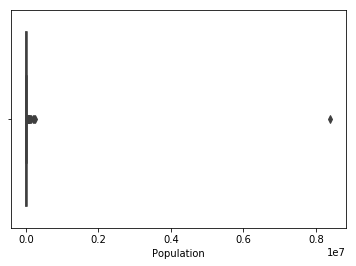

In [16]:
## using a boxplot can show if there are values that are abnormal
p1= sns.boxplot(df_task["Population"])

plt.show()

In [17]:
## There is a value that seems to be much higher than the rest. 

df_task.loc[df_task['Population'] == df_task['Population'].max(), :]

,City,Population,Murder,Robbery,propCrime,Burglary
216,New York,8396126.0,335.0,19170.0,141971.0,16606.0


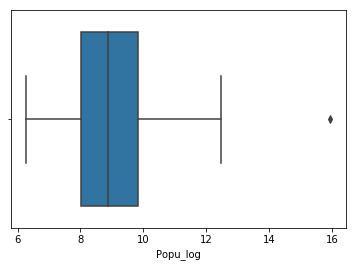

In [20]:
## New york has more than 8 milion in population. if we take the log of the population we 
## can graph the boxplot again and we will be able to see more info
df_task['Popu_log'] = np.log(df_task['Population'])

p2= sns.boxplot(df_task["Popu_log"])

plt.show()

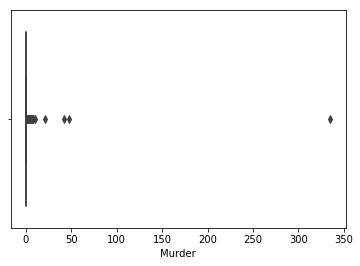

In [21]:
## Even with 
p3= sns.boxplot(df_task["Murder"])

plt.show()

In [22]:
df_task.loc[df_task['Murder'] == df_task['Murder'].max(), :]



,City,Population,Murder,Robbery,propCrime,Burglary,Popu_log
216,New York,8396126.0,335.0,19170.0,141971.0,16606.0,15.943281


In [45]:
df_task['Murder_sqrt'] = np.sqrt(df_task['Murder'])

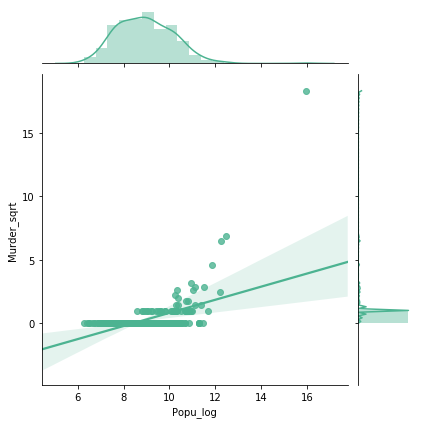

In [47]:
x = df_task['Popu_log']
y = df_task['Murder_sqrt']
sns.jointplot(x, y, kind="reg", color="#4CB391")

plt.show()


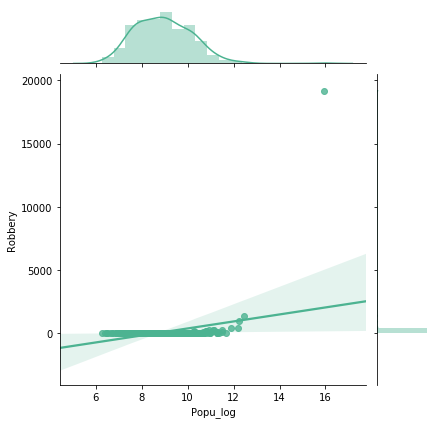

In [25]:

y2 = df_task['Robbery']
sns.jointplot(x, y2, kind="reg", color="#4CB391")

plt.show()



## Feature Engineering
Although New york seems to be an anamolous value, it is still necessery for our model. I have used the log function to create an easy to visiulize version of the population.
in this part i will create the three new features. Population ^ 2 and two catagorical features from the robbery and Murder features. 

In [28]:
## 1. creating population squared
df_task['Pop_squared'] = np.square(df_task['Population'])

## 2. creating Robbery catagory with values == 0 are 0 and values > 0 are 1

df_task['robb_cat'] = (df_task['Robbery'] != 0) * 1

## 3. creating Murder catagory with values == 0 are 0 and values > 0 are 1

df_task['murd_cat'] = (df_task['Murder'] != 0) * 1

In [37]:
df = df_task[df_task.isnull().any(axis=1)]

df.head()

,City,Population,Murder,Robbery,propCrime,Burglary,Popu_log,Murder_log,Pop_squared,robb_cat,murd_cat


In [38]:
regr = linear_model.LinearRegression()
Y = df_task['propCrime'].values.reshape(-1, 1)
X = df_task[['Population','Pop_squared','robb_cat', 'murd_cat']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [[  3.46570268e-02  -2.11108019e-09  -9.62774363e+01   1.51866535e+01]]

Intercept: 
 [-109.57533562]

R-squared:
0.996124710499


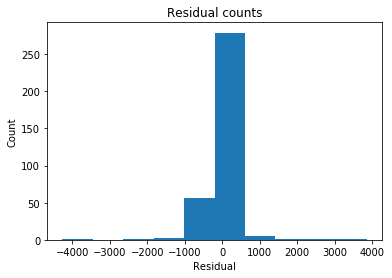

In [41]:
predicted = regr.predict(X).ravel()
actual = (df_task['propCrime'])

# Calculate the error, also called the residual.
residual = actual - predicted

# This looks a bit concerning.
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

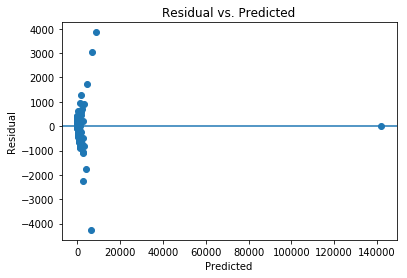

In [42]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

# Hm... looks a bit concerning.